## Brachistochrone Problem via [JuMP](https://jump.dev/) and [NLopt](https://github.com/JuliaOpt/NLopt.jl)

According to Eq. (8) in [here](https://mathworld.wolfram.com/BrachistochroneProblem.html), we need to minimize
$$
    T = \int_{P_1}^{P_2} \sqrt{\frac{1 + (y'(x))^2}{2g y(x)}} dx,
$$
where $P_{1, 2}$ are fixed points. Which is different from what you had. Using the rectangular rule, we get

$$
    T \approx \Delta x \left( 
        \sqrt{\frac{1 + (y'(x_0))^2}{2g y(x_0)}} 
        + \sum_{k=1}^{n-1} \sqrt{\frac{1 + (y'(x_k))^2}{2g y(x_k)}}
        + \sqrt{\frac{1 + (y'(x_n))^2}{2g y(x_n)}} 
    \right).
$$

Using the finite difference, 

$$
   T \approx \Delta x \left( 
        \sqrt{\frac{1 + (y'(x_0))^2}{2g y(x_0)}} 
        + \sum_{k=1}^{n-1} \sqrt{\frac{1 + (y'(x_k))^2}{2g y(x_k)}}
        + \sqrt{\frac{1 + (y'(x_n))^2}{2g y(x_n)}} 
    \right)
$$

Using the finite difference, 

$$
   T \approx \Delta x \left( 
        \sqrt{\frac{1 + [y(x_0) - y(x_1)]^2 / \Delta x^2}{2g y(x_0)}} 
        + \sum_{k=1}^{n-1} \sqrt{\frac{1 + [y(x_k) - y(x_{k-1})]^2  / \Delta x^2}{2g y(x_k)}}
        + \sqrt{\frac{1 + [y(x_n) - y(x_{n-1})]^2 / \Delta x^2}{2g y(x_n)}} 
    \right)
$$
$$
   = \Delta x \left( 
        \sqrt{\frac{1 + [y(x_0) - y(x_1)]^2 / \Delta x^2}{2g y(x_0)}} 
        + \sqrt{\frac{1 + [y(x_0) - y(x_1)]^2 / \Delta x^2}{2g y(x_1)}}
        + \sum_{k=2}^{n-1} \sqrt{\frac{1 + [y(x_k) - y(x_{k-1})]^2  / \Delta x^2}{2g y(x_k)}}
        + \sqrt{\frac{1 + [y(x_n) - y(x_{n-1})]^2 / \Delta x^2}{2g y(x_n)}} 
    \right).
$$

Hence,
$$
    P_1 = (x_0, y(x_0)), \qquad P_2 = (x_n, y(x_n)).
$$

We will choose $x_0 = 0$ and $y(x_0) = 1$. 

In [109]:
# number of points
n = 100

const g = 9.81

x = range(0, 11, n + 1)
dx = x[2] - x[1]

y_end = 3

function T(y...)
    integral = sqrt(
        (1 + (1 - y[1]) ^ 2 / dx ^2) / (2 * g)
    ) 
    + 
    sqrt(
        (1 + (1 - y[1]) ^ 2 / dx ^2) / (2 * g * y[1])
    )
    
    integral += sum(
        sqrt(
            (1 + (y[k] - y[k - 1]) ^ 2 / dx ^2) / (2 * g * y[k])
        )
        for k = 2:length(y)
    )
    
    integral += sqrt(
        (1 + (y_end - y[end]) ^ 2 / dx ^2) / (2 * g * y_end)
    )
    
    return integral
end

T (generic function with 1 method)

In [110]:
using JuMP
using NLopt

model = Model(NLopt.Optimizer)

@variable(model, y[1:n-1])

y_init_guess = range(1, y_end, n + 1)
for k = 1:length(y)
    set_start_value(y[k], y_init_guess[k])
end

register(model, :T, length(y), T; autodiff = true)

@NLobjective(model, Min, T(y...))

set_optimizer_attribute(model, "algorithm", :LD_TNEWTON_PRECOND)

JuMP.optimize!(model)

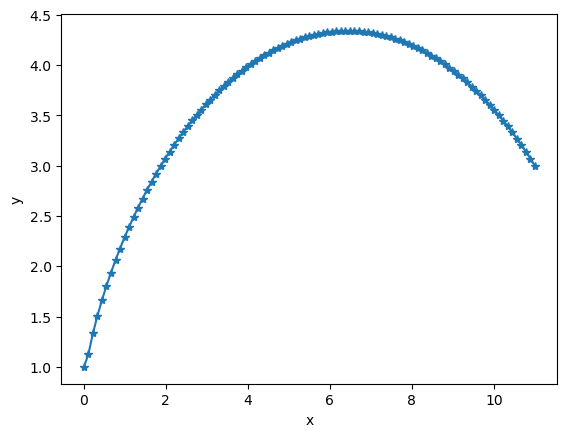

In [111]:
using PyPlot

plot(x, [1; map(value, y); y_end], "*-")
xlabel("x")
ylabel("y")
show()